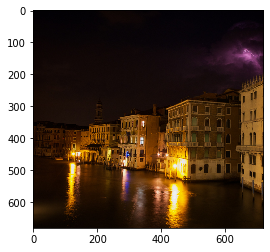

In [27]:
import numpy as np
import cv2
from scipy import sparse
import scipy.sparse.linalg
import sys

%matplotlib inline
import matplotlib.pyplot as plt

"""
Paper 1: http://www.dabi.temple.edu/~hbling/publication/LIME-tip.pdf
Paper 2: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.385.2768&rep=rep1&type=pdf
"""

input_image = cv2.imread("1.bmp")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,4))
plt.imshow(input_image)

In [22]:
def SpedUp_Solver(img, alpha = 0.5, epsilon = 0.001, weight_strategy = 1, sigma = 2, kernel_size = 5, gamma = 0.8):
    """
    This function estimates the illumination map based on Sped-Up Solver of Equation 9 of the paper 1
    @Params:
    img: Input Image 
    alpha: Weight given to the gradients
    epsilon: A small value to avoid division by zero
    weight_strategy: Based on the value given {1, 2, 3}, weights are calculated accordingly
    sigma: Variance for calculating Gaussian Filter. Applicable only when weight_strategy = 3
    kernel_size: Size of Gaussian Kernel to use. Applicable only when weight_strategy = 3
    gamma: Parameter to adjust brightness of Illumination Map
    """
    img = img / 255
    
    #Iniatial Illumination Estimamtion based on Equation 2 of Paper - 1
    T_hat = np.max(img, axis = 2)
    m, n = T_hat.shape
    
    #Calculate Gradients of T_hat along X and Y directions
    delT_hatx = calculate_del(T_hat, 'x')
    delT_haty = calculate_del(T_hat, 'y')
    
    #Calculate Weights based on input
    if weight_strategy == 1:
        wx = np.ones((m, n))
        wy = np.ones((m, n))
        #print(wx.shape, wy.shape)
    elif weight_strategy == 2:
        wx = 1 / (np.abs(delT_hatx) + epsilon)
        wy = 1 / (np.abs(delT_haty) + epsilon)
        #print(wx.shape, wy.shape)
    elif weight_strategy == 3:
        gaussian_kernelx = cv2.getGaussianKernel(kernel_size, sigma).reshape(1, -1)
        gaussian_kernely = gaussian_kernelx.reshape(-1, 1)
        gaussianX = cv2.filter2D(delT_hatx, ddepth = -1, kernel = gaussian_kernelx)
        gaussianY = cv2.filter2D(delT_haty, ddepth = -1, kernel = gaussian_kernely)
        
        g = np.sum(gaussian_kernelx)
        wx = g / (np.abs(gaussianX) + epsilon)
        wy = g / (np.abs(gaussianY) + epsilon)
    else:
        print("Undesired value for Weight Strategy is given!!!!")
        return 0
    
    wx = wx / (np.abs(delT_hatx) + epsilon)
    wy = wy / (np.abs(delT_haty) + epsilon)
    
    #Call Function to Solve for T of equation 19 of paper 1
    T = Solve_Eqn(wx, wy, 0.5, T_hat)
    
    #Do Gamma Correction based on requirement
    T = np.power(T, gamma)
    
    img2 = np.empty((m, n, 3))
    img2[:, :, 0] = T
    img2[:, :, 1] = T
    img2[:, :, 2] = T
    
    #Calcualted illuminated image based on equation 3
    r = img / (img2 + epsilon)
    
    #Clip and fix the illuminated image to allowed values
    r = r * 255
    r = np.clip(r, 0, 255)
    r = np.fix(r).astype(np.uint8)
    return r

In [23]:
def Solve_Eqn(wx, wy, alpha, T_hat):
    """
    This function is to evaluate the equation 19 of paper - 1
    The function takes help from paper - 2 to estimate the matrix A where Ax = b
    
    @Params:
    wx: Weights given to gradients along X direction
    Wy: Weights given to gradients along Y direction
    alpha: Overall scalar weights assigned to the gradients
    T_hat: Initial Estimated Illumination Map
    """
    #Get size of the illumination map
    m,n = T_hat.shape
    mn = m * n
    
    #Flatten T_hat so that it forms the RHS of Ax=b 
    t_hat = T_hat.flatten('C')
    
    wx = alpha * wx
    wy = alpha * wy
    
    #Calcuate Sparse Matrix A based on equations 3 and 4 in paper 2
    wx_vec = wx.flatten('C')
    wy_vec = wy.flatten('C')
    
    wxa = np.hstack((wx[:, -1].reshape(-1, 1), wx[:, 0:-1].reshape(-1, n - 1)))
    wya = np.vstack((wy[-1, :].reshape(1, -1), wy[0: -1,:].reshape(m - 1, -1)))
    wxa_vec = wxa.flatten('C')
    wya_vec = wya.flatten('C')
    
    
    dx1 = np.hstack((wx[:, -1].reshape(-1, 1), np.zeros((m, n - 1))))
    dx2 = np.hstack([wx[:, 0:-1].reshape(-1, n - 1), np.zeros((m, 1))])
    dx3 = np.hstack([np.zeros((m, 1)), wx[:, 0:-1].reshape(-1, n-1)])
    dx4 = np.hstack([np.zeros((m, n-1)), wx[:, -1].reshape(-1, 1)])
    Ax = scipy.sparse.spdiags(np.array([-dx1.flatten('C'), -dx2.flatten('C'), -dx3.flatten('C'), -dx4.flatten('C')]), np.array([-n + 1, -1, 1, n - 1]), mn, mn)
    
    dy1 = np.vstack([wy[-1, :].reshape(1, -1),np.zeros((m - 1, n))])
    dy2 = np.vstack([wy[0: -1, :].reshape(m - 1, -1),np.zeros((1, n))])
    dy3 = np.vstack([np.zeros((1, n)), wy[0:-1, :].reshape(m - 1, -1)])
    dy4 = np.vstack([np.zeros((m - 1, n)), wy[0, :].reshape(1, -1)])
    Ay = scipy.sparse.spdiags(np.array([-dy1.flatten('C'), -dy2.flatten('C'), -dy3.flatten('C'), -dy4.flatten('C')]), np.array([-mn + n, -n, n, mn - n]), mn, mn)

    diag = scipy.sparse.spdiags(np.array([wx_vec + wy_vec + wxa_vec + wya_vec + 1]), np.array([0]), mn, mn)
    A = Ax + Ay + diag
    
    #Since matrix A is very huge, we will leverage the fact that it is sparse and calculate its approximate inverse using
    #Sparse methods available
    
    # The resulting object is an approximation to the inverse of A
    m1 = scipy.sparse.linalg.spilu(A.tocsc())
    
    # construct a linear operator
    m2 = scipy.sparse.linalg.LinearOperator((mn, mn), m1.solve)
    
    # use preconditioned conjugate gradient method to solve the linear system Ax=b (where A=a, x=t, b=t~)
    t, converged = scipy.sparse.linalg.bicgstab(a, t_hat, tol=1e-1, maxiter=2000, M=m2)
    
    #Verify if the above methos has converged. If not, print out a warning
    if converged != 0:
        print('Warning: Estimation may not be what is desired')

    t = t.reshape((m, n), order='C')

    # clip negative numbers & normalize
    t = np.clip(t, 0, sys.maxsize)
    t = t / (np.max(t) + 0.01)

    return t

In [24]:
def calculate_del(T, direction = 'x'):
    """
    Function to calculate directional derivative using forward difference
    @Params:
    T: Matrix whose Directional Derivative is to be calculated
    direction: {x, y} Direction along which derivative needs to be calcuated
    """
    if direction == 'x':
        #Calcuate forward difference along X direction
        forward_diff = np.diff(T, axis = 1)
        diff = (T[:, 0] - T[:, -1]).reshape(-1, 1)
        forward_diff = np.hstack([forward_diff, diff])
    elif direction == 'y':
        #Calcuate forward difference along Y direction
        forward_diff = np.diff(T, axis = 0)
        diff = T[0, :] - T[-1, :].reshape(1, -1)
        forward_diff = np.vstack([forward_diff, diff])
        
    return forward_diff

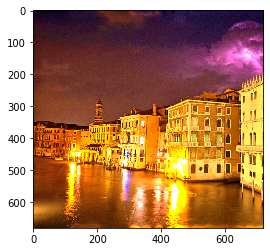

In [25]:
output = SpedUp_Solver(input_image, alpha = 0.5, epsilon = 0.1, weight_strategy = 2)
plt.imshow(output)

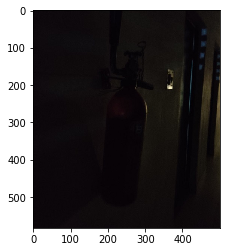

In [170]:
plt.imshow(input_image)

In [164]:
cv2.imshow('Input', raw_image)
cv2.imshow('output', output)
cv2.waitKey()
cv2.destroyAllWindows()